In [3]:
import pandas as pd

samples = ["CCMP1545", "CCMP490", "RCC114", "RCC1614", "RCC1698", "RCC1749", 
           "RCC2482", "RCC3052", "RCC373", "RCC465", "RCC629", "RCC647", 
           "RCC692", "RCC693", "RCC833", "RCC835"]

tsv = "/scratch1/chris/introner-genotyping-pipeline/graph_blast_results/RCC1749.ortholog_results.tsv"
# Extract sample name from file path
sample = tsv.split("/")[-1].split(".")[0]

# Load the original dataframe
df = pd.read_csv(tsv, sep="\t")

# Extract contig, start, and end directly using vectorized string operations
new_df = df[['ortholog_id']].copy()
new_df = new_df.drop_duplicates(ignore_index=True)
new_df['contig'] = new_df['ortholog_id'].str.split(":").str[0]
coords = new_df['ortholog_id'].str.split(":").str[1].str.split("|").str[0]
new_df['left_flank_start'] = coords.str.split("-").str[0].astype(int)
new_df['right_flank_end'] = coords.str.split("-").str[1].astype(int)
new_df['presence'] = 0  # Assuming presence is always 1
new_df['sample'] = sample

# Define column order explicitly to avoid any misalignment
new_df = new_df[['ortholog_id', 'contig', 'left_flank_start', 'right_flank_end', 'presence', 'sample']]

# Combine the old and new dataframes efficiently
combined_df = pd.concat([df, new_df], ignore_index=True)
combined_df = combined_df.sort_values(['ortholog_id', 'sample'])
# Assign generic ortholog_id values
unique_ids = combined_df['ortholog_id'].unique()
id_mapping = {orth_id: f'ortholog_id_{i:04d}' for i, orth_id in enumerate(unique_ids, start=1)}
combined_df['ortholog_id'] = combined_df['ortholog_id'].map(id_mapping)

# List of expected samples
samples = ["CCMP1545", "CCMP490", "RCC114", "RCC1614", "RCC1698", "RCC1749", 
           "RCC2482", "RCC3052", "RCC373", "RCC465", "RCC629", "RCC647", 
           "RCC692", "RCC693", "RCC833", "RCC835"]

# Identify unique ortholog IDs
unique_orthologs = combined_df['ortholog_id'].unique()

# Group by ortholog_id to find missing samples
existing_samples = combined_df.groupby('ortholog_id')['sample'].apply(set)

# List to store missing sample rows
missing_rows = []

for ortholog_id in unique_orthologs:
    # Find missing samples for this ortholog_id
    present_samples = existing_samples.get(ortholog_id, set())
    missing_samples = set(samples) - present_samples
    
    # Create rows for missing samples
    for sample in missing_samples:
        missing_rows.append({
            'ortholog_id': ortholog_id,
            'contig': '?',
            'left_flank_start': 0,
            'right_flank_end': 0,
            'presence': 3,
            'sample': sample
        })

# Convert missing rows into a dataframe
missing_df = pd.DataFrame(missing_rows)

# Combine with the original dataframe
final_df = pd.concat([combined_df, missing_df], ignore_index=True)
final_df = final_df.sort_values(['ortholog_id', 'sample'], ignore_index=True)


In [4]:
final_df.head(16)

,ortholog_id,contig,left_flank_start,right_flank_end,presence,sample
0,ortholog_id_0001,?,0,0,3,CCMP1545
1,ortholog_id_0001,?,0,0,3,CCMP490
2,ortholog_id_0001,?,0,0,3,RCC114
3,ortholog_id_0001,?,0,0,3,RCC1614
4,ortholog_id_0001,?,0,0,3,RCC1698
5,ortholog_id_0001,RCC1749#0#intronerless_contig_10,1009999,1010368,0,RCC1749
6,ortholog_id_0001,?,0,0,3,RCC2482
7,ortholog_id_0001,RCC3052-deplete#0#14#2,1009231,1009594,0,RCC3052
8,ortholog_id_0001,?,0,0,3,RCC373
9,ortholog_id_0001,?,0,0,3,RCC465


In [5]:
print(final_df.loc[final_df['left_flank_start'] == 24908])

           ortholog_id                            contig  left_flank_start  \
1461  ortholog_id_0092  RCC1749#0#intronerless_contig_12             24908   

      right_flank_end  presence   sample  
1461            25220         0  RCC1749  


In [19]:
import pandas as pd


metadata_file = "/scratch1/chris/introner-genotyping-pipeline/genotype_matrixes/genotype_matrix.metadata.2.updated.tsv"
calls_file = "/scratch1/chris/introner-genotyping-pipeline/genotype_matrixes/genotype_matrix.calls.2.updated.tsv"

meta_df = pd.read_csv(metadata_file, sep="\t", index_col=0)
meta_g1 = meta_df[~meta_df['sample_name'].isin(['RCC1749', 'RCC3052'])]

calls_df = pd.read_csv(calls_file, sep="\t", header=0)
calls_g1 = calls_df.drop(['RCC1749', 'RCC3052'], axis=1)
calls_g1 = calls_g1[~calls_g1.isin([3]).any(axis=1)]

In [20]:
print(meta_g1.loc[meta_g1['ortholog_id'] == 'ortholog_id_3726'])

            ortholog_id sample_name                      contig   start  \
59600  ortholog_id_3726    CCMP1545       CCMP1545#0#scaffold_7  163360   
59601  ortholog_id_3726     CCMP490  CCMP490-intronerized#0#7#0  163150   
59602  ortholog_id_3726      RCC114   RCC114-intronerized#0#7#0  163019   
59603  ortholog_id_3726     RCC1614  RCC1614-intronerized#0#7#0  163469   
59604  ortholog_id_3726     RCC1698  RCC1698-intronerized#0#7#0  163476   
59606  ortholog_id_3726     RCC2482  RCC2482-intronerized#0#7#0  163638   
59608  ortholog_id_3726      RCC373   RCC373-intronerized#0#7#0  163026   
59609  ortholog_id_3726      RCC465   RCC465-intronerized#0#7#0  163512   
59610  ortholog_id_3726      RCC629   RCC629-intronerized#0#7#0  163864   
59611  ortholog_id_3726      RCC647   RCC647-intronerized#0#7#0  163497   
59612  ortholog_id_3726      RCC692   RCC692-intronerized#0#7#0  163312   
59613  ortholog_id_3726      RCC693   RCC693-intronerized#0#7#0  163302   
59614  ortholog_id_3726  

In [22]:
print(calls_g1.loc[calls_g1['ortholog_id'] == 'ortholog_id_3726'])

           ortholog_id  CCMP1545  CCMP490  RCC114  RCC1614  RCC1698  RCC2482  \
3725  ortholog_id_3726         0        0       0        0        0        0   

      RCC373  RCC465  RCC629  RCC647  RCC692  RCC693  RCC833  RCC835  
3725       0       0       1       0       0       0       0       0  


In [23]:
filtered_matrix = calls_g1[~(calls_g1.iloc[:, 1:] == 3).any(axis=1)]
    
# Count number of 1s (absences) per row, excluding the ortholog_id column
polymorphism_counts = (filtered_matrix.iloc[:, 1:] == 1).sum(axis=1)

# Calculate frequency spectrum
total_samples = len(filtered_matrix.columns) - 1  # Subtract 1 for ortholog_id column
afs = pd.Series(0, index=range(total_samples + 1))  # Initialize counts for all possible values
value_counts = polymorphism_counts.value_counts()
afs[value_counts.index] = value_counts.values

Number of fixed sites (present in all samples) excluded from plot: 3744


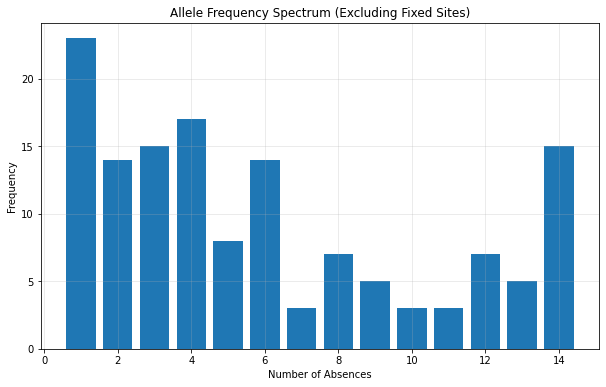

In [25]:
import matplotlib.pyplot as plt
    
# Create new series excluding the 0 absences (shared by all)
polymorphic_afs = afs[1:]

plt.figure(figsize=(10, 6))
plt.bar(polymorphic_afs.index, polymorphic_afs.values)
plt.xlabel('Number of Absences')
plt.ylabel('Frequency')
plt.title('Allele Frequency Spectrum (Excluding Fixed Sites)')
plt.grid(True, alpha=0.3)

# Optionally print the number of fixed sites that were excluded
print(f"Number of fixed sites (present in all samples) excluded from plot: {afs[0]}")

plt.show()

In [2]:
import pandas as pd

def analyze_genotype_matrix(filepath):
    """
    Analyze genotype matrix for various statistics about ortholog groups
    
    Parameters:
    filepath (str): Path to the genotype matrix TSV file
    
    Returns:
    dict: Dictionary containing all computed statistics
    """
    # Read the data
    df = pd.read_csv(filepath, sep='\t')
    
    # Define groups
    group1_samples = ['CCMP1545', 'CCMP490', 'RCC114', 'RCC1614', 'RCC1698', 
                     'RCC2482', 'RCC373', 'RCC465', 'RCC629', 'RCC647', 
                     'RCC692', 'RCC693', 'RCC833', 'RCC835']
    group2_samples = ['RCC1749', 'RCC3052']
    
    # Calculate basic statistics
    stats = {}
    
    # Total number of ortholog groups
    stats['total_orthologs'] = len(df)
    
    # Callable across all samples (no 3s)
    all_samples = df.drop('ortholog_id', axis=1)
    stats['callable_all'] = all_samples.apply(lambda row: 3 not in row.values, axis=1).sum()
    
    # Group-specific statistics
    group1_df = df[group1_samples]
    group2_df = df[group2_samples]
    
    # Callable in each group
    stats['callable_group1'] = group1_df.apply(lambda row: 3 not in row.values, axis=1).sum()
    stats['callable_group2'] = group2_df.apply(lambda row: 3 not in row.values, axis=1).sum()
    
    # Analyze variation within groups
    def analyze_group_variation(group_df):
        no_threes_mask = group_df.apply(lambda row: 3 not in row.values, axis=1)
        callable_rows = group_df[no_threes_mask]
        
        # Count polymorphic (multiple values) and monomorphic (single value) groups
        polymorphic = callable_rows.apply(lambda row: len(set(row)) > 1, axis=1).sum()
        monomorphic = callable_rows.apply(lambda row: len(set(row)) == 1, axis=1).sum()
        
        return polymorphic, monomorphic
    
    stats['polymorphic_group1'], stats['monomorphic_group1'] = analyze_group_variation(group1_df)
    stats['polymorphic_group2'], stats['monomorphic_group2'] = analyze_group_variation(group2_df)
    
    return stats

def print_statistics(stats):
    """Print formatted statistics"""
    print(f"Analysis of Ortholog Groups:\n")
    print(f"Total number of ortholog groups: {stats['total_orthologs']}")
    print(f"Number of ortholog groups callable across all samples: {stats['callable_all']}")
    print(f"\nGroup 1 Statistics (excluding RCC1749 and RCC3052):")
    print(f"Callable loci: {stats['callable_group1']}")
    print(f"Polymorphic groups: {stats['polymorphic_group1']}")
    print(f"Monomorphic groups: {stats['monomorphic_group1']}")
    print(f"\nGroup 2 Statistics (only RCC1749 and RCC3052):")
    print(f"Callable loci: {stats['callable_group2']}")
    print(f"Polymorphic groups: {stats['polymorphic_group2']}")
    print(f"Monomorphic groups: {stats['monomorphic_group2']}")

# Usage example:
if __name__ == "__main__":
    filepath = "/scratch1/chris/introner-genotyping-pipeline/genotype_matrixes/genotype_matrix.calls.2.updated.tsv"  # Update with your file path
    stats = analyze_genotype_matrix(filepath)
    print_statistics(stats)

Analysis of Ortholog Groups:

Total number of ortholog groups: 5872
Number of ortholog groups callable across all samples: 55

Group 1 Statistics (excluding RCC1749 and RCC3052):
Callable loci: 3793
Polymorphic groups: 75
Monomorphic groups: 3718

Group 2 Statistics (only RCC1749 and RCC3052):
Callable loci: 1005
Polymorphic groups: 30
Monomorphic groups: 975
